In [16]:
#librerías de sistema y manejo de datos
import os
import numpy as np
import pandas as pd

#visualización
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#procesamiento de imágenes
from PIL import Image

#modelado
import tensorflow as tf
from tensorflow.keras import backend as K  
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#importación de datasets
from kaggle.api.kaggle_api_extended import KaggleApi

In [17]:
#crear ruta para el dataset

base_dir = os.path.join('../data/raw/waste_classification')

#lista vacía para guardar las imágenes

rows = []

#función para extraer las imágenes y formar el dataframe

for root, dirs, files in os.walk(base_dir):
    for fname in files:
        if fname.lower().endswith(('.jpg', 'jpeg', 'png', 'bmp', 'gif')):
            rel_dir = os.path.relpath(root, base_dir)
            parts = rel_dir.split(os.sep)
            class_name = parts[0]
            subclass = None
            for part in parts[1:]:
                if part and part != class_name:
                    subclass = part
                    break
            if subclass is None:
                subclass = class_name
            file_path = os.path.join(rel_dir, fname)
            rows.append({
                'file_name': file_path,
                'label': class_name,
                'subclass': subclass
            })

labels = pd.DataFrame(rows)

#guardar dataframe como csv

labels.to_csv(os.path.join('..', 'data', 'labels.csv'), index=False)

print(f"Total imágenes indexadas: {len(labels)}")
print(labels[['file_name', 'label', 'subclass']].head())

Total imágenes indexadas: 2902
                                           file_name           label  \
0  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
1  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
2  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
3  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   
4  Non-Recyclable/Non-Recyclable/ceramic_product/...  Non-Recyclable   

          subclass  
0  ceramic_product  
1  ceramic_product  
2  ceramic_product  
3  ceramic_product  
4  ceramic_product  


## EDA

El siguiente EDA se conforma de algunos gráficos donde se busca entender mejor la distribución de las imágenes. 

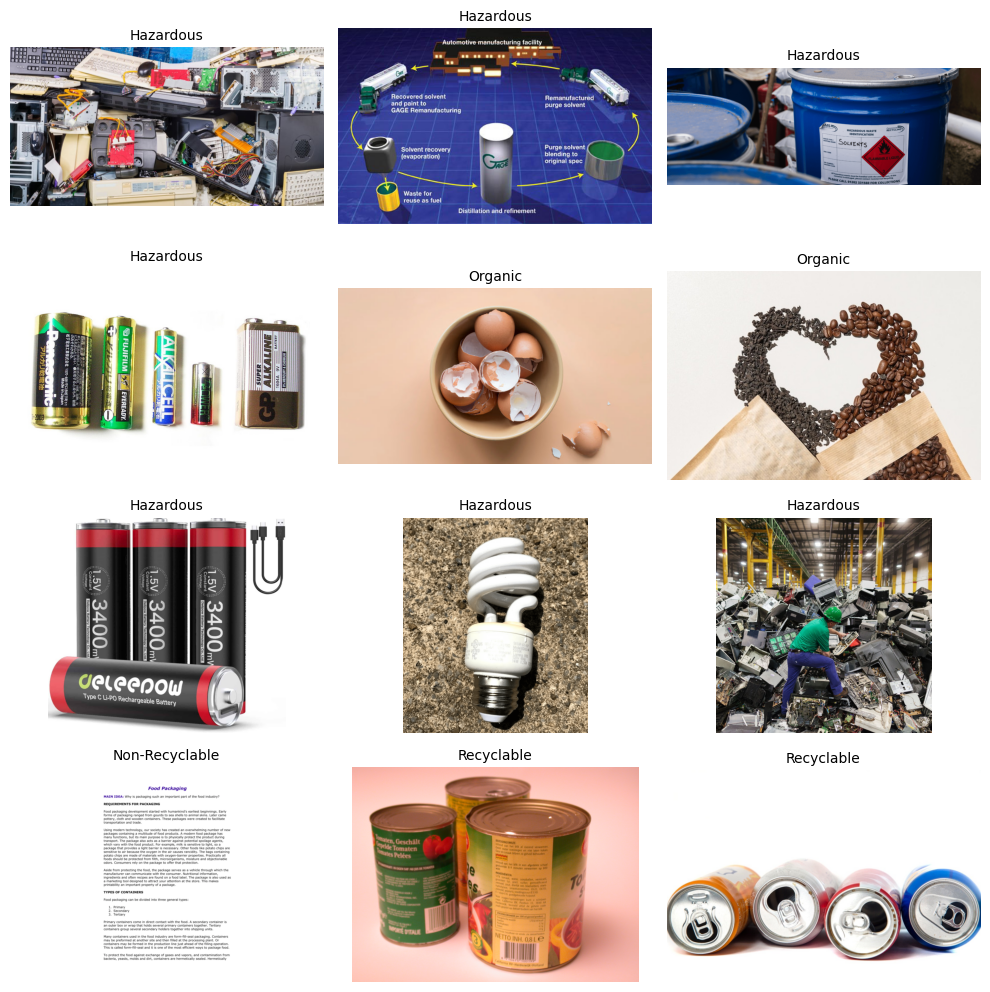

In [18]:
#tomar 12 muestras aleatorias
sample = labels.sample(n=12, random_state=123).reset_index(drop=True)

#crear gráfico con las muestras
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    #construir ruta completa a la imagen
    img_path = os.path.join(base_dir, sample.loc[i, 'file_name'])
    img = Image.open(img_path)
    
    ax.imshow(img)  
    ax.set_title(sample.loc[i, 'label'], fontsize=10)  
    ax.axis('off')

plt.tight_layout()
plt.show()

In [19]:
#generar un histograma 

histogram = px.histogram(labels['label'])
histogram

In [20]:
#agrupar y contar por jerarquía

counts = labels.groupby(['label', 'subclass']).size().reset_index(name='count')

#generar listas para elñ treemap

classes = counts['label'].unique().tolist()
class_counts = counts.groupby('label')['count'].sum().reindex(classes).tolist()
subclasses = counts['subclass'].tolist()
parents = [''] * len(classes) + counts['label'].tolist()
values = class_counts + counts['count'].tolist()
labels_list = classes + subclasses

#generar el treemap

fig = go.Figure(go.Treemap(
    labels=labels_list,
    parents=parents,
    values=values,
    branchvalues='total'
))

fig.update_layout(title='Treemap de clases y subclases')
fig.show()

In [21]:
#verificar errores en las imágenes

errores = []
total   = len(labels)

#verificar la integridad de cada imagen

for idx, row in labels.iterrows():
    img_path = os.path.join(base_dir, row['file_name'])
    try:
        with Image.open(img_path) as img:
            img.verify()    
    except Exception as e:
        errores.append((row['file_name'], str(e)))

#mostrar los errores

buenas = total - len(errores)
print(f'Imágenes válidas: {buenas}')
print(f'Imágenes corruptas o ilegibles: {len(errores)} de {total}')

if errores:
    print('\nPrimeros 5 errores:')
    for ruta, msg in errores[:5]:
        print(f"  • {ruta}: {msg}")

/Users/luistorres/Documents/Proyectos/GreenVisionModel/vision_ml/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:900: UserWarning:

Truncated File Read



Imágenes válidas: 2902
Imágenes corruptas o ilegibles: 0 de 2902


In [22]:
#verificar tamaños y formatos

props = []

for _, row in labels.iterrows():
    img_path = os.path.join(base_dir, row['file_name'])
    with Image.open(img_path) as img:
        props.append({
            "file_name": row['file_name'],
            "label":     row['label'],
            "format":    img.format,      
            "width":     img.width,
            "height":    img.height
        })

#crear dataFrame con las propiedades
dims_df = pd.DataFrame(props)

#resumen de formatos
print('Formatos de imagen y su conteo:')
print(dims_df['format'].value_counts(), "\n")

#resumen de dimensiones únicas
size_counts = (
    dims_df
    .groupby(['width', 'height'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
print('Tamaños de imagen (width × height) y su frecuencia:')
print(size_counts)

Formatos de imagen y su conteo:
format
JPEG    2473
PNG      361
WEBP      47
GIF       18
MPO        3
Name: count, dtype: int64 

Tamaños de imagen (width × height) y su frecuencia:
      width  height  count
1055   1280     720     60
1183   1500    1101     42
1085   1300     956     37
1001   1200     800     31
589     800     534     30
...     ...     ...    ...
579     800     470      1
578     800     466      1
577     800     462      1
574     800     445      1
1543   7800    5200      1

[1544 rows x 3 columns]


In [23]:
#función para transformar imágenes a RGB y dimensionarlas

def load_and_preprocess_image(path, size=(224, 224)):
 
    img = Image.open(path)
    
    #extraer primer frame si está animada/multipágina
    if getattr(img, "is_animated", False):
        img.seek(0)
    
    #convertir a RGB
    img = img.convert("RGB")
    
    #redimensionar (distorsión simple)
    img = img.resize(size)
    
    return img

In [24]:
#extraer las clases únicas

classes = np.unique(labels['label'])

#calcular pesos balanceados

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels['label'].values
)

#crear diccionario para Keras

class_weight = dict(zip(classes, weights))

print("Pesos por clase:")
for cls, w in class_weight.items():
    print(f"  • {cls}: {w:.2f}")

Pesos por clase:
  • Hazardous: 0.77
  • Non-Recyclable: 1.13
  • Organic: 1.10
  • Recyclable: 1.11


In [32]:
# Focal Loss custom con alpha por clase
def focal_loss(alpha=None, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        ce = -y_true * tf.math.log(y_pred)
        if alpha is not None:
            alpha_tensor = tf.convert_to_tensor(alpha, dtype=y_pred.dtype)
            alpha_factor = tf.reduce_sum(alpha_tensor * y_true, axis=1, keepdims=True)
            weight = alpha_factor * tf.pow(1 - y_pred, gamma)
        else:
            weight = tf.pow(1 - y_pred, gamma)
        fl = weight * ce
        return tf.reduce_mean(tf.reduce_sum(fl, axis=1))
    return loss_fn

# stratified split manual
train_df, val_df = train_test_split(
    labels,
    test_size=0.15,
    stratify=labels['label'],
    random_state=12345
)
print("Train:",  train_df['label'].value_counts())
print(" Val :",  val_df['label'].value_counts())

# calcular class_weight sobre el TRAIN
classes = np.unique(train_df['label'])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['label'].values
)
raw_class_weight = dict(zip(classes, weights))
print("Pesos por clase (raw):", raw_class_weight)

# generators SIN validation_split (aug. refinado)
data_root   = os.path.join('..','data','raw','waste_classification')
batch_size  = 32
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_root,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=12345
)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=data_root,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

indexed_class_weight = {
    train_gen.class_indices[name]: raw_class_weight[name]
    for name in classes
}
print("Pesos por índice de clase:", indexed_class_weight)

# construcción del modelo “congelado” con Focal Loss
def create_model(input_shape=(224,224,3), num_classes=4, lr=3e-4, dropout_rate=0.3):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    backbone.trainable = False

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    # Usa focal loss sin class_weight, o con alpha por clase, o solo class_weight (ver nota)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=focal_loss(alpha=None, gamma=2.0),  
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

num_classes = len(train_gen.class_indices)
model = create_model(
    input_shape=(224,224,3),
    num_classes=num_classes
)

# callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)
checkpoint = ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_loss'
)

# primer entrenamiento (head + Focal Loss)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    # class_weight=indexed_class_weight
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=2
)

# Antes del fine-tuning: congela BatchNorm
for layer in model.layers[0].layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Descongela solo capas convolucionales superiores (sin BatchNorm)
for layer in model.layers[0].layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Compilación del modelo para fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate más bajo para fine-tuning
    loss=focal_loss(alpha=None, gamma=2.0),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    # class_weight=indexed_class_weight
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=2
)

Train: label
Hazardous         800
Organic           563
Recyclable        556
Non-Recyclable    547
Name: count, dtype: int64
 Val : label
Hazardous         142
Organic            99
Recyclable         98
Non-Recyclable     97
Name: count, dtype: int64
Pesos por clase (raw): {'Hazardous': 0.770625, 'Non-Recyclable': 1.1270566727605118, 'Organic': 1.0950266429840143, 'Recyclable': 1.1088129496402879}
Found 2451 validated image filenames belonging to 4 classes.
Found 433 validated image filenames belonging to 4 classes.
Pesos por índice de clase: {0: 0.770625, 1: 1.1270566727605118, 2: 1.0950266429840143, 3: 1.1088129496402879}


/Users/luistorres/Documents/Proyectos/GreenVisionModel/vision_ml/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning:

Found 15 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.

/Users/luistorres/Documents/Proyectos/GreenVisionModel/vision_ml/lib/python3.9/site-packages/keras/src/preprocessing/image.py:1137: UserWarning:

Found 3 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.



Epoch 1/15


/Users/luistorres/Documents/Proyectos/GreenVisionModel/vision_ml/lib/python3.9/site-packages/PIL/Image.py:1056: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/Users/luistorres/Documents/Proyectos/GreenVisionModel/vision_ml/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:900: UserWarning:

Truncated File Read



77/77 - 43s - loss: 1.0243 - accuracy: 0.2950 - precision: 0.3163 - recall: 0.1036 - val_loss: 0.9287 - val_accuracy: 0.2240 - val_precision: 0.4348 - val_recall: 0.0231 - lr: 3.0000e-04 - 43s/epoch - 555ms/step
Epoch 2/15


/Users/luistorres/Documents/Proyectos/GreenVisionModel/vision_ml/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



77/77 - 42s - loss: 0.9386 - accuracy: 0.3358 - precision: 0.3782 - recall: 0.1077 - val_loss: 0.8127 - val_accuracy: 0.3395 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 3.0000e-04 - 42s/epoch - 550ms/step
Epoch 3/15
77/77 - 45s - loss: 0.8808 - accuracy: 0.3480 - precision: 0.4232 - recall: 0.1146 - val_loss: 1.1879 - val_accuracy: 0.3372 - val_precision: 0.3755 - val_recall: 0.2125 - lr: 3.0000e-04 - 45s/epoch - 586ms/step
Epoch 4/15

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
77/77 - 44s - loss: 0.8619 - accuracy: 0.3448 - precision: 0.4149 - recall: 0.1093 - val_loss: 0.9557 - val_accuracy: 0.3279 - val_precision: 0.4444 - val_recall: 0.0739 - lr: 3.0000e-04 - 44s/epoch - 578ms/step
Epoch 5/15
77/77 - 45s - loss: 0.8127 - accuracy: 0.3696 - precision: 0.4742 - recall: 0.1163 - val_loss: 0.8435 - val_accuracy: 0.3487 - val_precision: 0.2778 - val_recall: 0.0115 - lr: 1.5000e-04 - 45s/epoch - 585ms/step
Epoch 6/15
77/77 - 45s - loss: 0.8

Epoch 1/10
77/77 - 47s - loss: 0.8256 - accuracy: 0.3709 - precision_1: 0.4458 - recall_1: 0.1040 - val_loss: 0.7099 - val_accuracy: 0.4111 - val_precision_1: 0.5750 - val_recall_1: 0.0531 - lr: 1.0000e-05 - 47s/epoch - 617ms/step
Epoch 2/10
77/77 - 45s - loss: 0.7987 - accuracy: 0.3696 - precision_1: 0.4767 - recall_1: 0.1085 - val_loss: 0.7090 - val_accuracy: 0.4226 - val_precision_1: 0.5897 - val_recall_1: 0.0531 - lr: 1.0000e-05 - 45s/epoch - 587ms/step
Epoch 3/10
77/77 - 46s - loss: 0.8064 - accuracy: 0.3778 - precision_1: 0.4874 - recall_1: 0.1106 - val_loss: 0.7079 - val_accuracy: 0.4342 - val_precision_1: 0.6462 - val_recall_1: 0.0970 - lr: 1.0000e-05 - 46s/epoch - 597ms/step
Epoch 4/10
77/77 - 47s - loss: 0.8084 - accuracy: 0.3884 - precision_1: 0.4862 - recall_1: 0.1081 - val_loss: 0.7221 - val_accuracy: 0.4065 - val_precision_1: 0.6471 - val_recall_1: 0.1270 - lr: 1.0000e-05 - 47s/epoch - 613ms/step
Epoch 5/10

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873

In [ ]:
#guardar el modelo

model_dir = '../api/models/greenvision_model'
model_dir = os.path.abspath(model_dir)

print(f"Guardando modelo en: {model_dir}")
model.save(model_dir)


Guardando modelo en: /Users/luistorres/Documents/Proyectos/GreenVisionModel/api/models/greenvision_model
INFO:tensorflow:Assets written to: /Users/luistorres/Documents/Proyectos/GreenVisionModel/api/models/greenvision_model/assets


INFO:tensorflow:Assets written to: /Users/luistorres/Documents/Proyectos/GreenVisionModel/api/models/greenvision_model/assets
